# Machine Learning Project 

*Lavinia Benetollo 3265865, Natali Dzneladze 3258252 Giulia Marcantonio 3307112*

*May 16, 2025*

## 1. Exploration Data Analysis

Import libraries and load data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# set seed for reproducibility
RANDOM_STATE = 18  

# to have a general overview of the dataset
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15391 entries, 0 to 15390
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   15391 non-null  int64  
 1   id                           15391 non-null  int64  
 2   short_name                   15391 non-null  object 
 3   long_name                    15391 non-null  object 
 4   player_positions             15391 non-null  object 
 5   overall                      15391 non-null  int64  
 6   potential                    15391 non-null  int64  
 7   value_eur                    15333 non-null  float64
 8   wage_eur                     15342 non-null  float64
 9   age                          15391 non-null  int64  
 10  dob                          15391 non-null  object 
 11  height_cm                    15391 non-null  int64  
 12  weight_kg                    15391 non-null  int64  
 13  club_team_id    

In [24]:
# to generate summary statistics for the DataFrame
train.describe() 

,Unnamed: 0,id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,15391.000000,15391.000000,15391.000000,15391.000000,1.533300e+04,15342.000000,15391.000000,15391.000000,15391.000000,15342.000000,...,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,1729.000000
mean,7695.000000,231528.535573,65.769866,71.086219,2.851328e+06,8610.310402,25.210902,181.347671,75.016698,50564.380133,...,57.898967,46.477292,47.906309,45.766097,16.478851,16.268858,16.128452,16.320772,16.586447,36.426258
std,4443.143332,27015.569028,6.890025,6.112911,7.528281e+06,18559.644411,4.753887,6.850746,7.072550,54394.414397,...,12.206433,20.243681,21.296095,20.821395,17.662887,16.924093,16.633380,17.151288,17.975868,10.748515
min,0.000000,41.000000,47.000000,49.000000,9.000000e+03,456.558174,16.000000,155.000000,51.000000,1.000000,...,12.000000,4.000000,5.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000
25%,3847.500000,214610.500000,61.000000,67.000000,4.750000e+05,947.936111,21.000000,176.000000,70.000000,467.000000,...,50.000000,29.000000,28.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,27.000000
50%,7695.000000,236573.000000,66.000000,71.000000,9.750000e+05,2841.616875,25.000000,181.000000,75.000000,1935.000000,...,59.000000,52.000000,55.000000,53.000000,11.000000,11.000000,11.000000,11.000000,11.000000,36.000000
75%,11542.500000,253613.000000,70.000000,75.000000,2.000000e+06,7683.740466,29.000000,186.000000,80.000000,111138.000000,...,66.000000,63.000000,65.000000,63.000000,14.000000,14.000000,14.000000,14.000000,14.000000,45.000000
max,15390.000000,264638.000000,92.000000,93.000000,1.375000e+08,331680.463188,54.000000,203.000000,110.000000,115820.000000,...,95.000000,92.000000,93.000000,92.000000,91.000000,92.000000,93.000000,92.000000,90.000000,65.000000


### 1.1 Missing values

We want to investigate which features miss more values and need imputation/encoding hence we build a data frame with the 20 columns that have the highest fraction of missing values. We also select the columns missing more than 15% of data and collect them in drop_missing, to drop them in the preprocessing stage.

In [8]:
# calculate percentage of missing values for every column
missing_pct = (train.isnull().sum() / len(train) * 100)

# extract the 20 worst columns, turn into a DataFrame
top20_missing = (
    missing_pct
    .sort_values(ascending=False)   # sort by % of missing values 
    .head(20)                       # top-20
    .reset_index()                  # turn into 2-column DF
    .rename(columns={'index': 'column', 0: 'pct_missing'})
    .assign(pct_missing=lambda d: d['pct_missing'].round(1))  # 1-dec place
)

print(top20_missing)

# extract the columns that miss more than 15% of the values (6 columns) to drop later in the preprocessing step
drop_missing = train.isnull().sum().nlargest(6).index


                  column  pct_missing
0   nation_jersey_number         96.1
1        nation_position         96.1
2       club_loaned_from         94.3
3            player_tags         92.5
4      goalkeeping_speed         88.8
5          player_traits         51.6
6                 physic         11.2
7              defending         11.2
8                passing         11.2
9               shooting         11.2
10                  pace         11.2
11             dribbling         11.2
12    release_clause_eur          6.1
13           club_joined          6.0
14             value_eur          0.4
15             club_name          0.3
16           league_name          0.3
17          league_level          0.3
18         club_position          0.3
19    club_jersey_number          0.3


### 1.2 Numerical and Categorical variables
Identification and count of numerical and categorical features.

In [31]:
# Identify the numerical columns dropping the id features 
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Identify the categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Print the number of numerical and categorical columns
print(f"Numerical columns ({len(numerical_cols)})")
print(f"Categorical columns ({len(categorical_cols)})")


Numerical columns (60)
Categorical columns (16)


### 1.3 Irrelevant features 

In the dataset there are some irrelevant features that we should drop because they don't provide any useful information to the model (more detailed explanation in the report). They're identified here and they will be dropped during the preprocessing.

In [6]:
irrelevant_features = [
        'Unnamed: 0', 'id', 'short_name', 'long_name',
        'dob', 'nationality_id', 'club_jersey_number', 'club_team_id'
    ] 

### 1.3 Target variable "value_eur"

We investgate the distribution of the target value value_eur through histogram and boxplot.

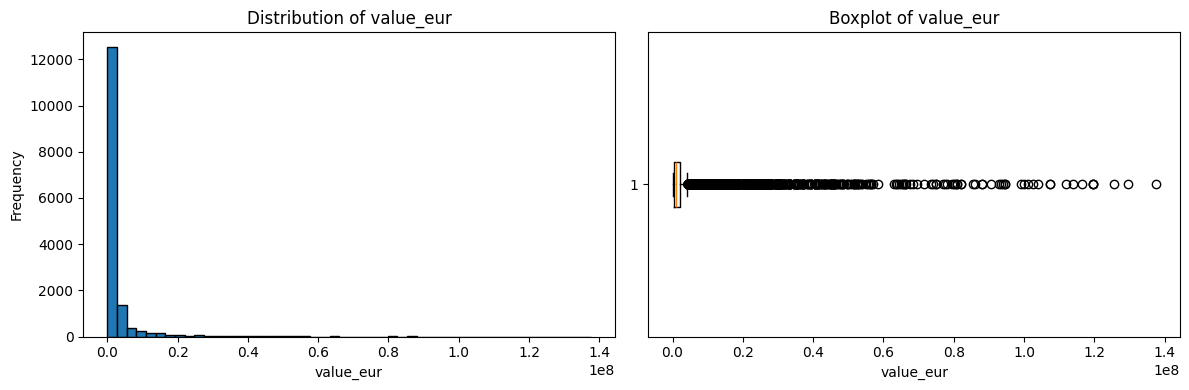

In [9]:
# Prepare side-by-side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram
axes[0].hist(train['value_eur'].dropna(), bins=50, edgecolor='black')
axes[0].set_title('Distribution of value_eur')
axes[0].set_xlabel('value_eur')
axes[0].set_ylabel('Frequency')

# Boxplot
axes[1].boxplot(train['value_eur'].dropna(), vert=False)
axes[1].set_title('Boxplot of value_eur')
axes[1].set_xlabel('value_eur')

plt.tight_layout()
plt.show()

We can notice from the plots above that the distribution of the target variable is highly right skewed, therefore we log transform it.

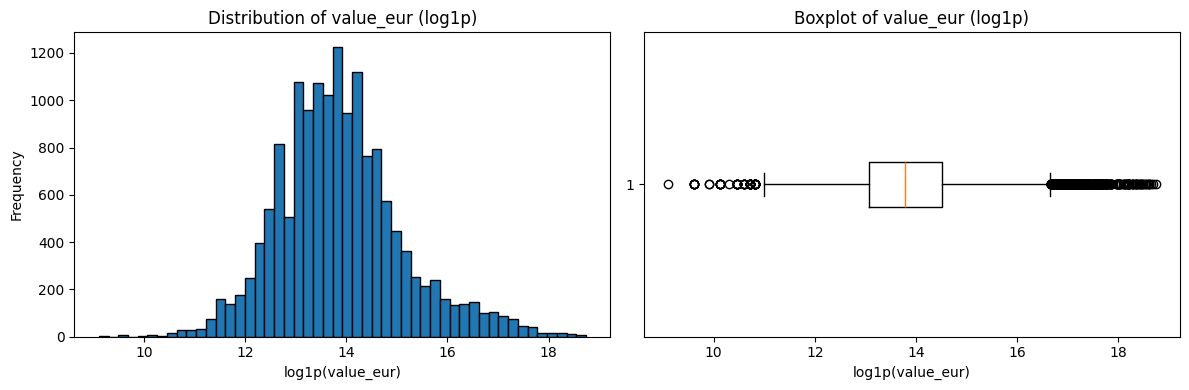

In [10]:
# Create the log-transformed target
log_target = np.log1p(train['value_eur'].clip(lower=0))

# Prepare side-by-side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram of log1p(value_eur)
axes[0].hist(log_target.dropna(), bins=50, edgecolor='black')
axes[0].set_title('Distribution of value_eur (log1p)')
axes[0].set_xlabel('log1p(value_eur)')
axes[0].set_ylabel('Frequency')

# Boxplot of log1p(value_eur)
axes[1].boxplot(log_target.dropna(), vert=False)
axes[1].set_title('Boxplot of value_eur (log1p)')
axes[1].set_xlabel('log1p(value_eur)')

plt.tight_layout()
plt.show()

### 1.4 Correlation among variables 

The correlation matrix below serves as a tool in our feature analysis, allowing us to easily detect multicollinearity among variables that may impact model performance.

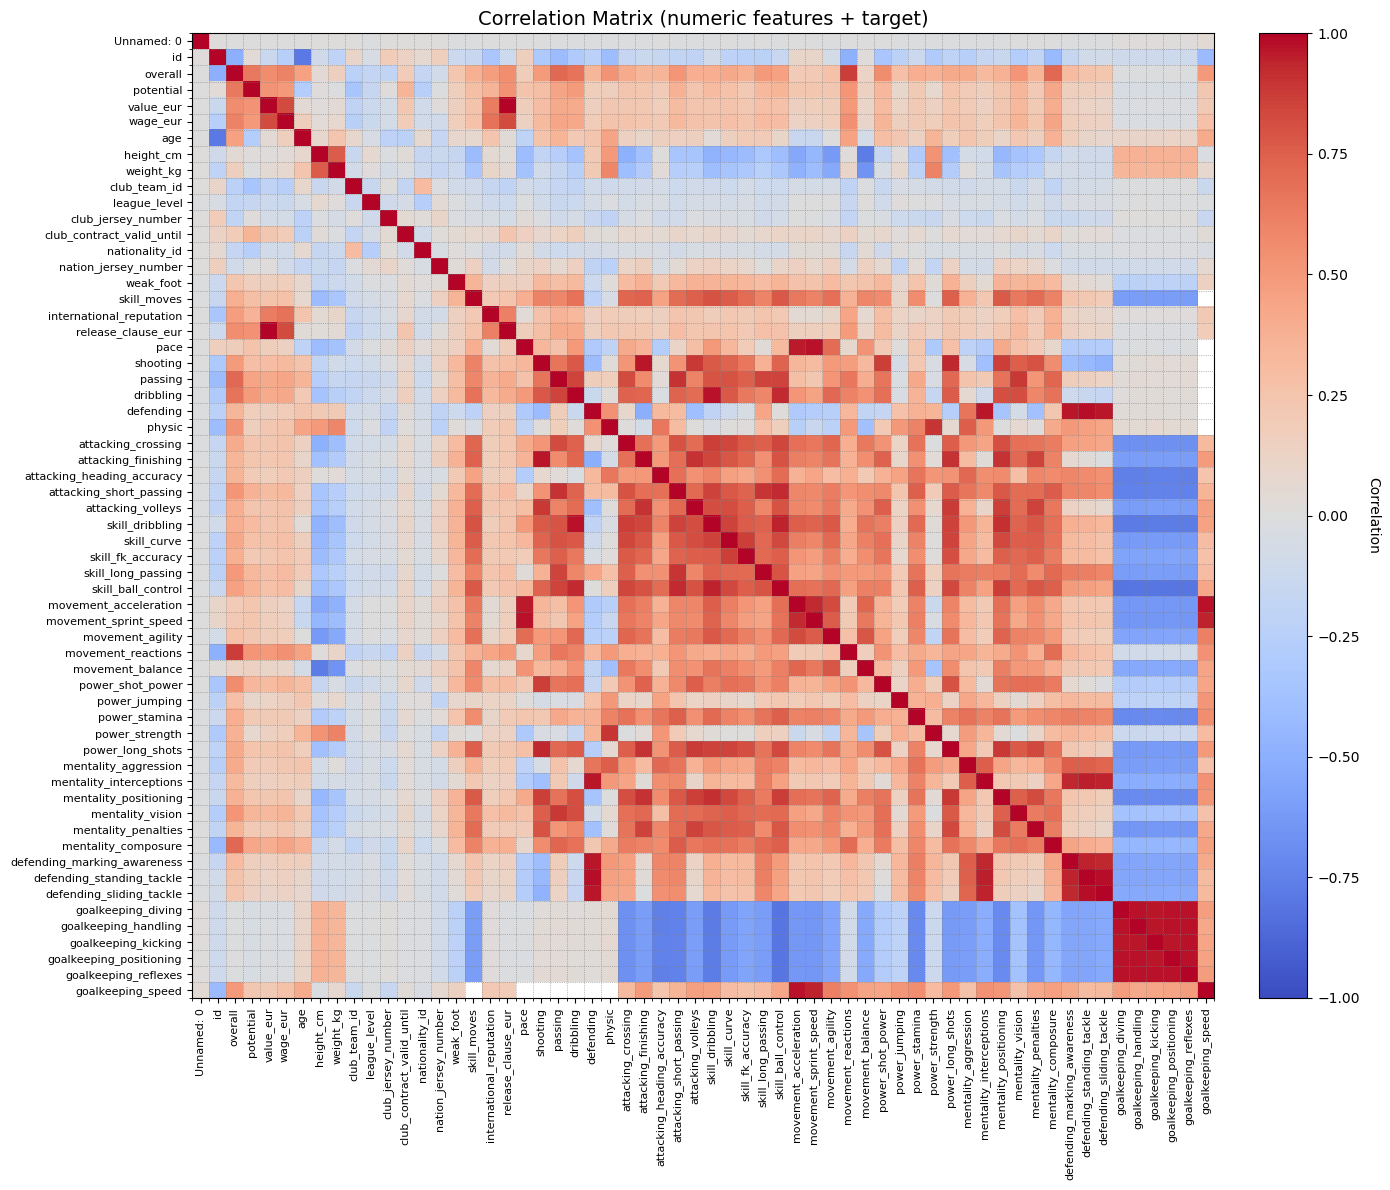

In [4]:
# Compute the correlation matrix for numeric columns only
corr = train.corr(numeric_only=True)

# Create figure and axis with larger size
fig, ax = plt.subplots(figsize=(14, 12))  # Bigger figure for readability

# Show correlation matrix with diverging color map for better contrast
im = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Set axis ticks and labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr.columns, fontsize=8)

# Add gridlines between cells
ax.set_xticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

# Add colorbar with label
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Correlation', rotation=270, labelpad=15)

# Add title
ax.set_title("Correlation Matrix (numeric features + target)", fontsize=14)

# Tight layout for proper spacing
plt.tight_layout()
plt.show()


Calculate the correlation among the variables and identify pairs of features with high correlation (> 0.7). For each such pair, compare their correlation with the target variable value_eur, and append the one with the lower correlation in cols_to_drop to reduce redundancy while preserving predictive power.

In [13]:
# Define the target variable and correlation threshold
TARGET  = 'value_eur'
THRESH  = 0.70

# Find all pairs of features that are highly correlated with each other (above the threshold)
pairs = [(c1, c2)
         for c1 in corr.columns if c1 not in irrelevant_features and c1 not in drop_missing
         for c2 in corr.columns if c1 not in irrelevant_features and c2 not in drop_missing
         if c1 != c2 and abs(corr.loc[c1, c2]) > THRESH and TARGET not in (c1, c2)]

# Initialize a set to collect columns to drop (avoid duplicates)
cols_to_drop = set()

# Loop through each highly correlated pair
for c1, c2 in pairs:
    # Keep the feature more strongly correlated with the target
    if corr.loc[c1, TARGET] > corr.loc[c2, TARGET]:
        cols_to_drop.add(c2)  # Drop c2 if c1 is more useful
    else:
        cols_to_drop.add(c1)  # Drop c1 if c2 is more useful

# Print the number and names of columns flagged for removal
print(f"{len(cols_to_drop)} columns flagged:\n{cols_to_drop}")

# Calculate the numerical features left in the model
cols_left = [col for col in corr.columns if col not in cols_to_drop and col != TARGET and col not in irrelevant_features and col not in drop_missing]
print(f"\n{len(cols_left)} numerical features remaining in the model:\n{sorted(cols_left)}")


39 columns flagged:
{'goalkeeping_positioning', 'skill_fk_accuracy', 'skill_long_passing', 'power_stamina', 'attacking_crossing', 'dribbling', 'attacking_short_passing', 'attacking_volleys', 'goalkeeping_handling', 'mentality_composure', 'attacking_heading_accuracy', 'wage_eur', 'goalkeeping_kicking', 'defending_sliding_tackle', 'mentality_aggression', 'goalkeeping_diving', 'shooting', 'mentality_positioning', 'defending_marking_awareness', 'skill_moves', 'skill_ball_control', 'defending_standing_tackle', 'movement_reactions', 'attacking_finishing', 'power_strength', 'mentality_penalties', 'movement_sprint_speed', 'movement_balance', 'passing', 'power_long_shots', 'movement_acceleration', 'id', 'skill_dribbling', 'mentality_interceptions', 'mentality_vision', 'height_cm', 'goalkeeping_reflexes', 'movement_agility', 'skill_curve'}

14 numerical features remaining in the model:
['age', 'club_contract_valid_until', 'defending', 'international_reputation', 'league_level', 'overall', 'pace'

### 1.5 Variables distributions
After excluding variables previously flagged for removal due to multicollinearity (cols_to_drop), irrelevant features (irrelevant_features), and those with the highest proportion of missing values, we are left with 16 numerical variables. For each of these, we plot both a histogram and a scatterplot against the log-transformed target (log(value_eur)) to examine their distributions and evaluate whether any transformation is necessary.

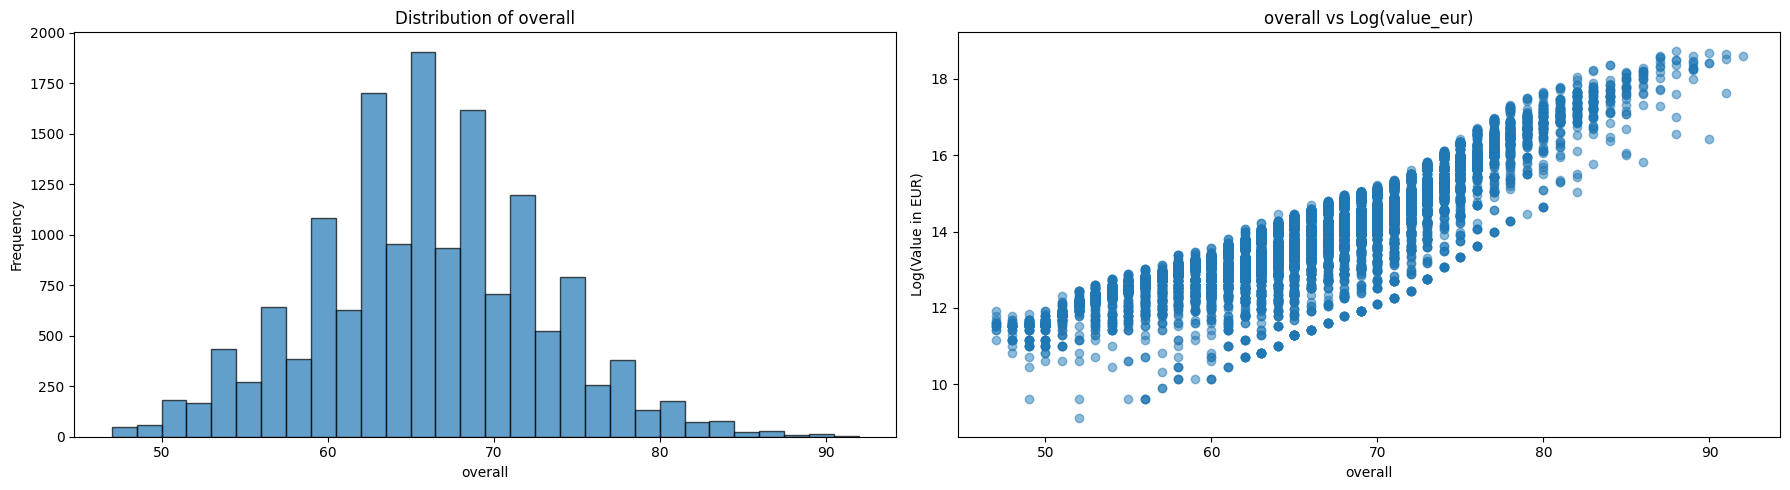

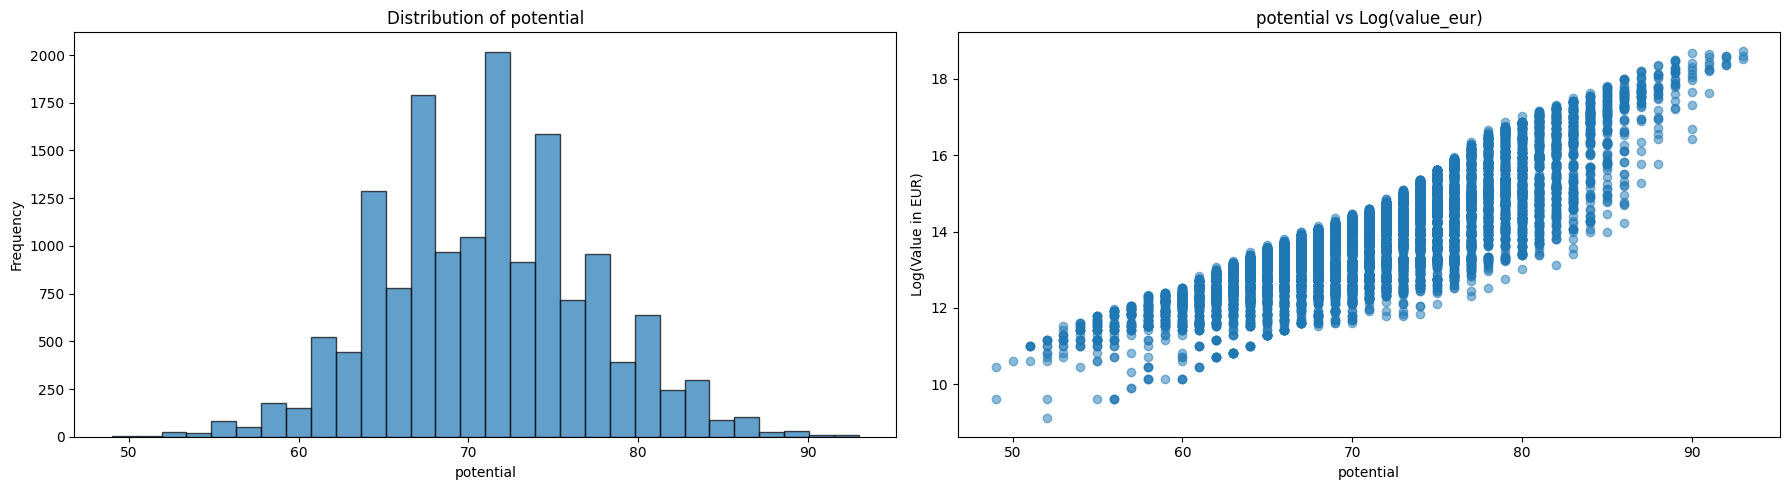

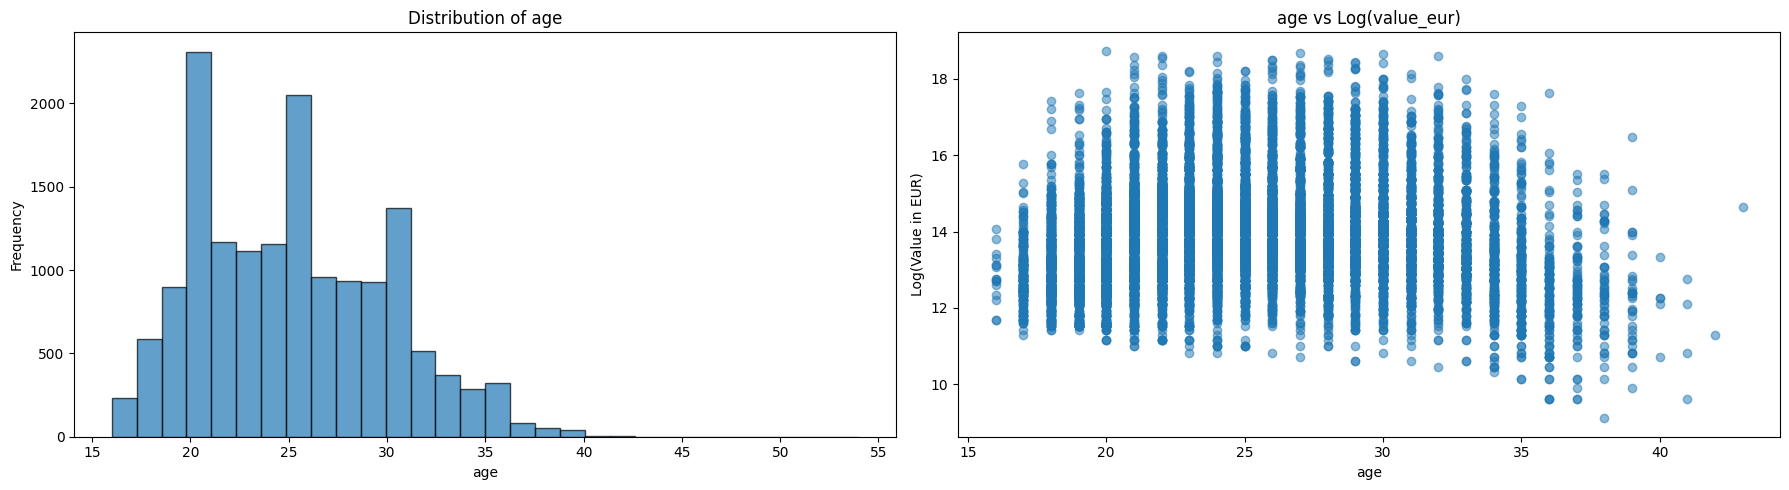

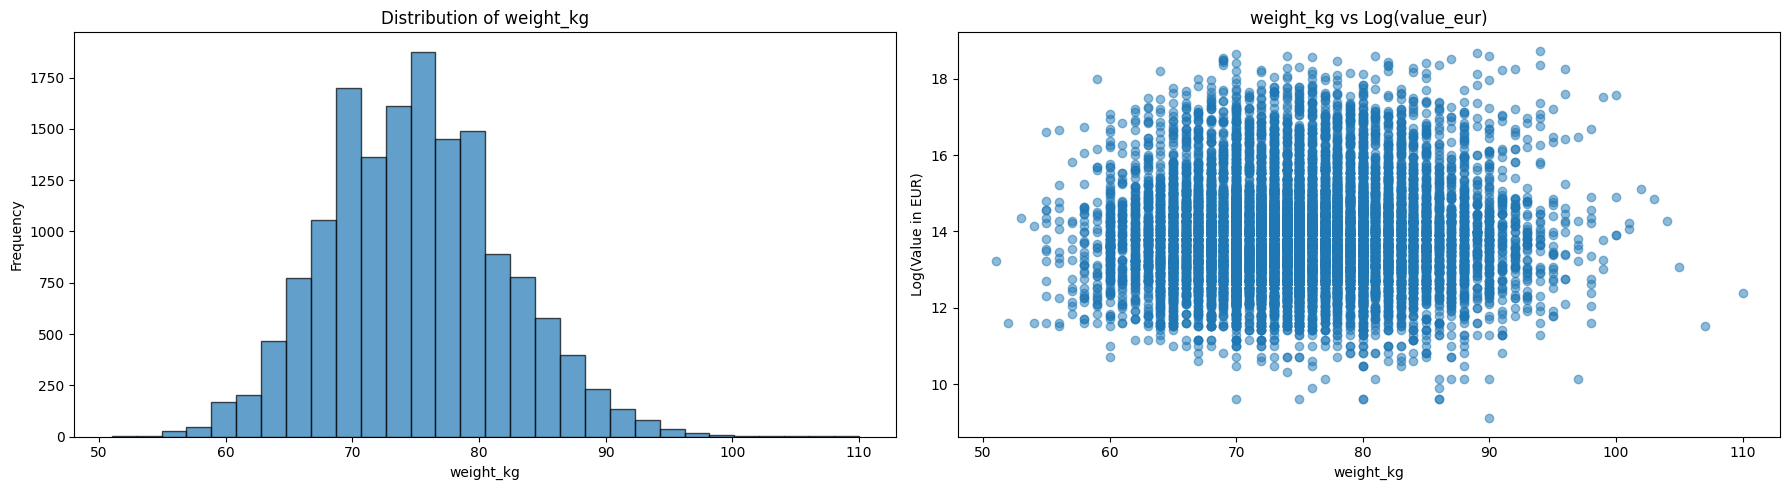

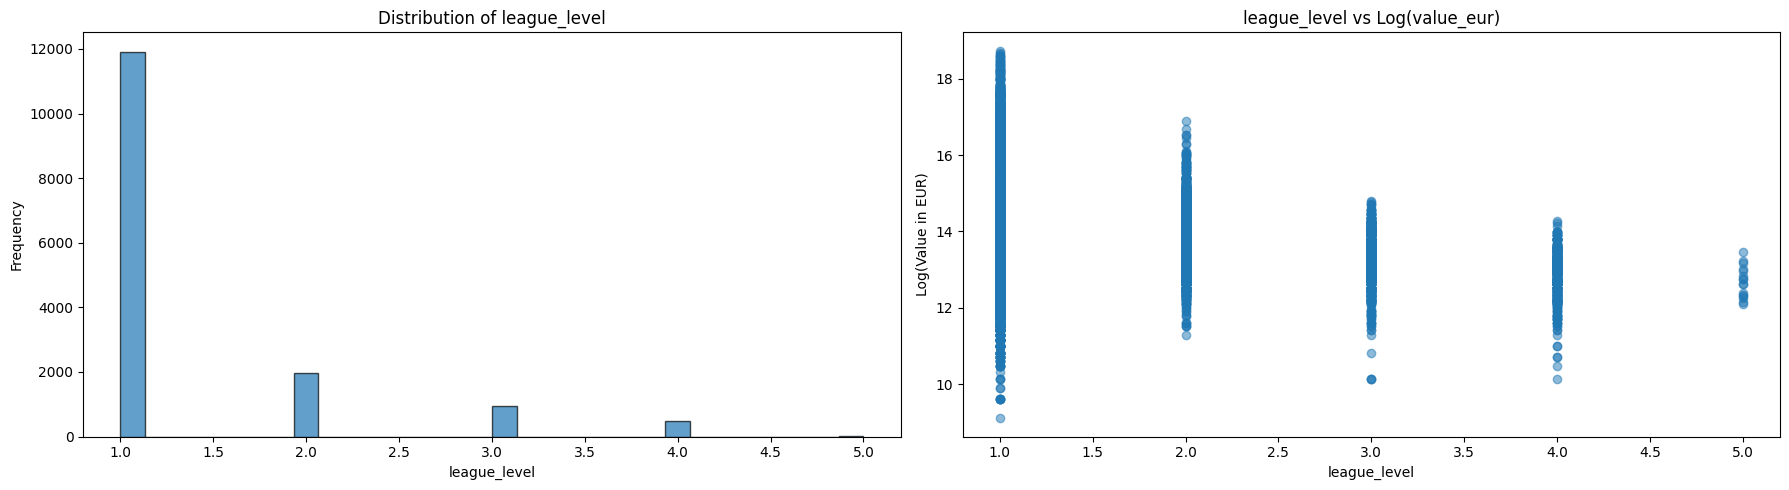

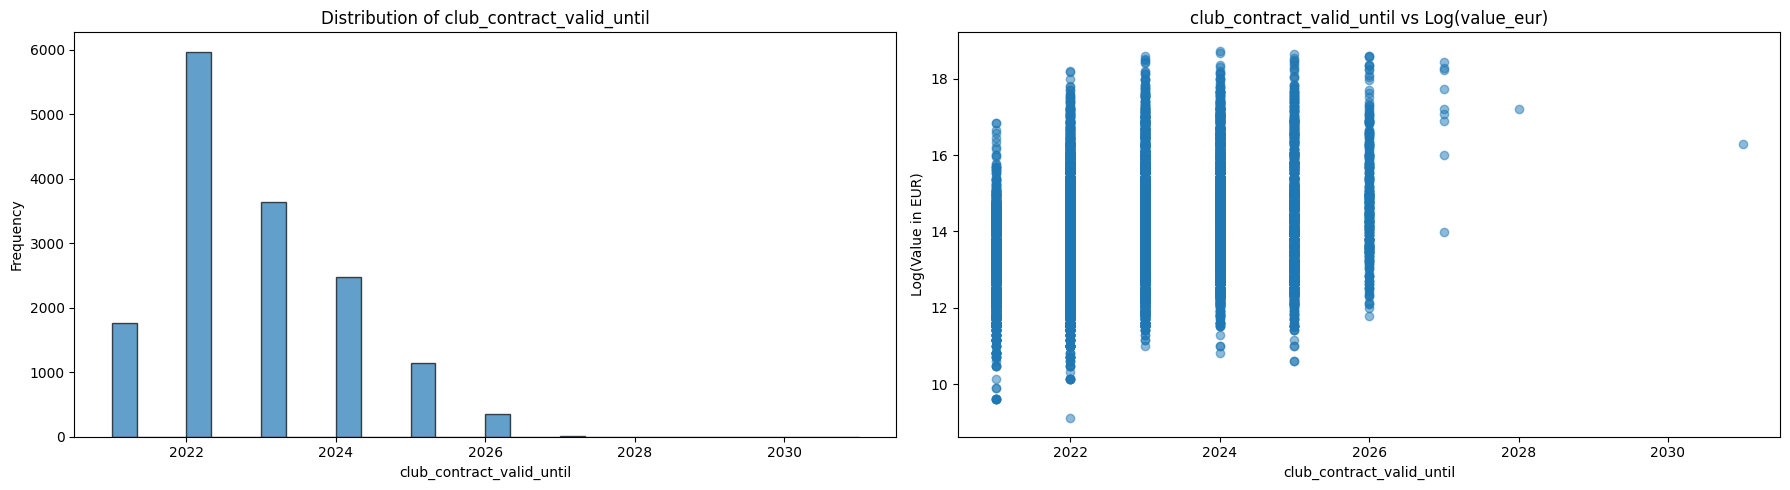

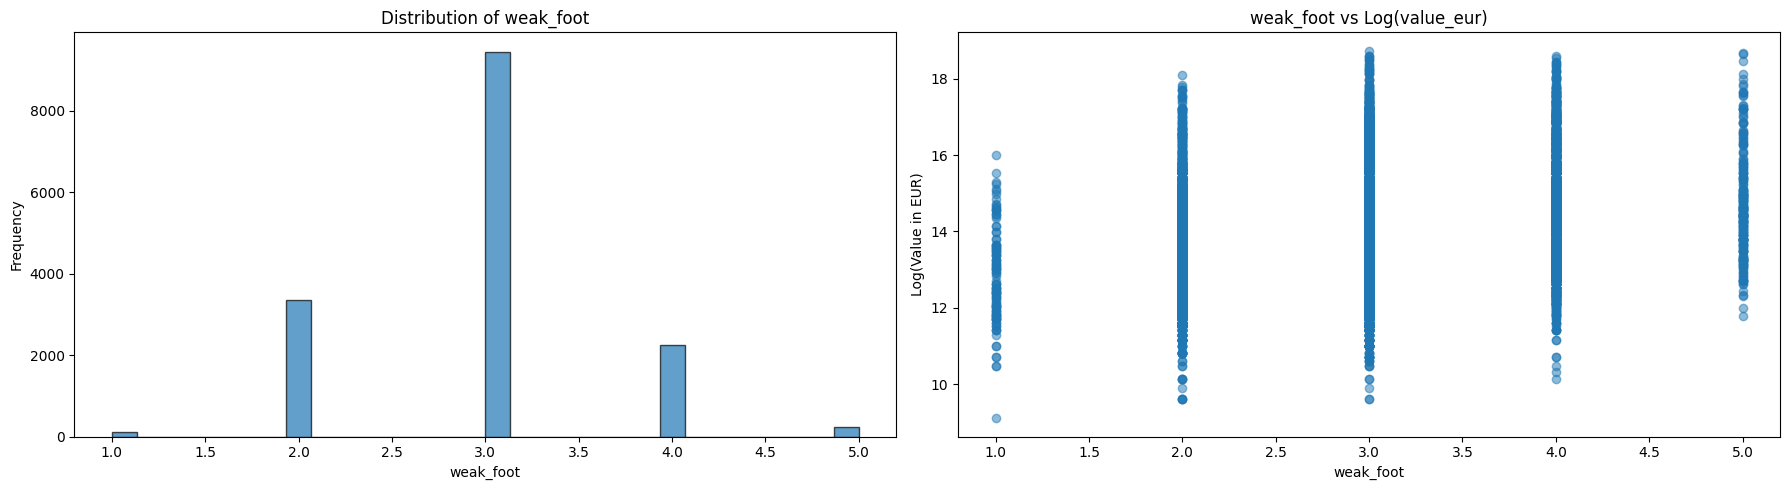

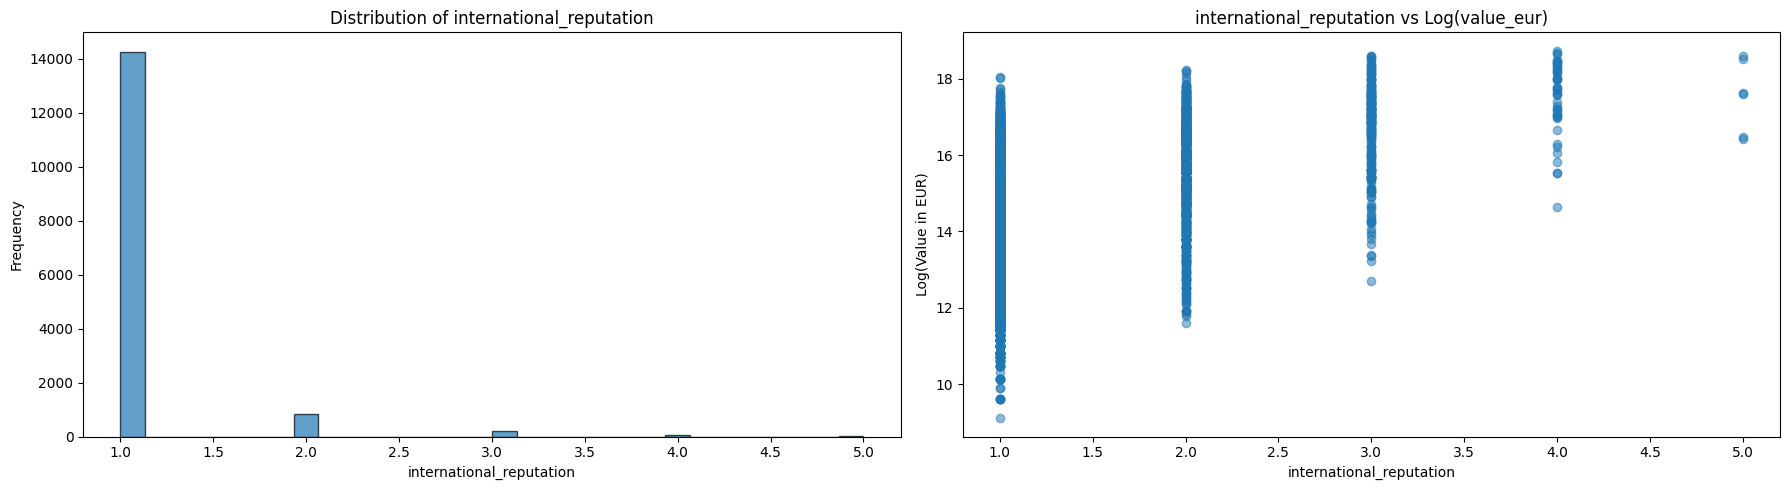

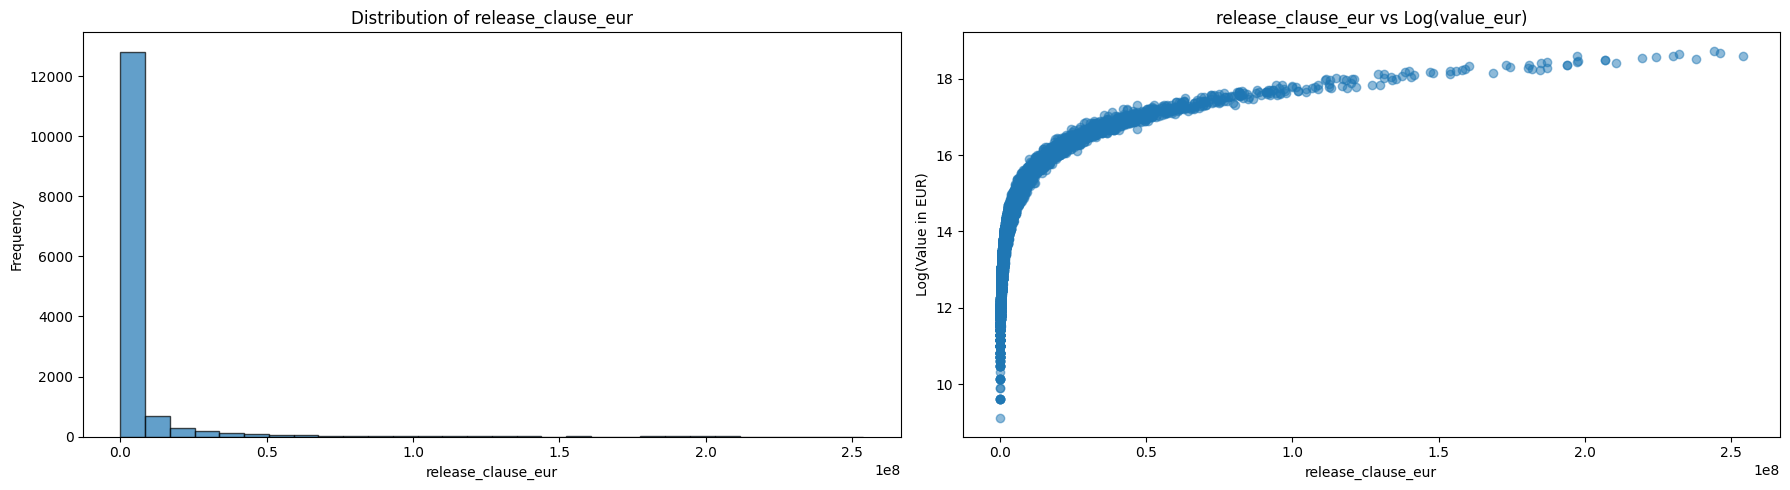

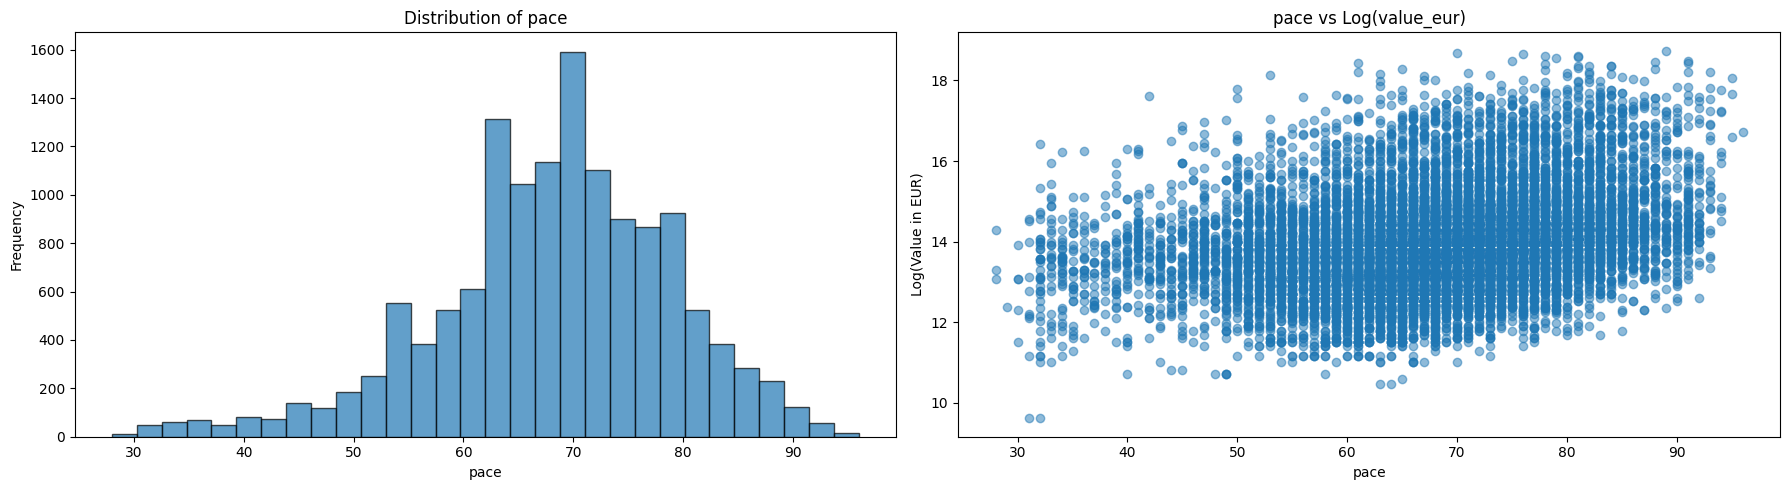

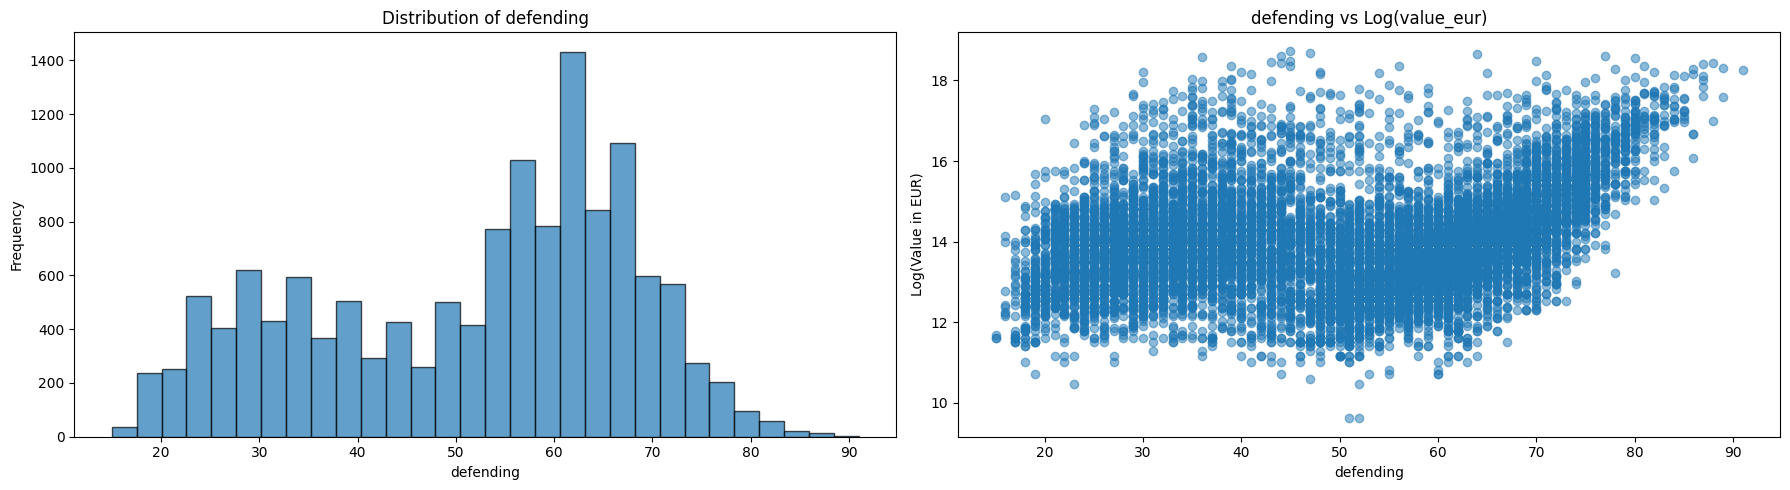

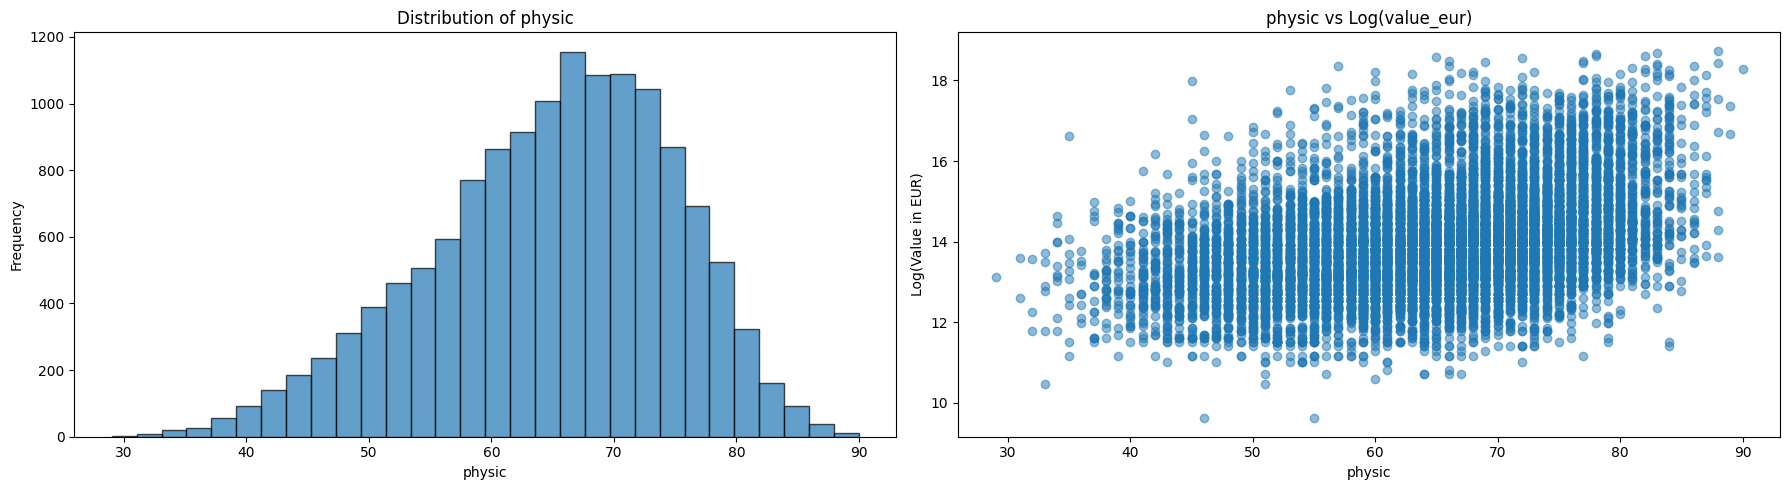

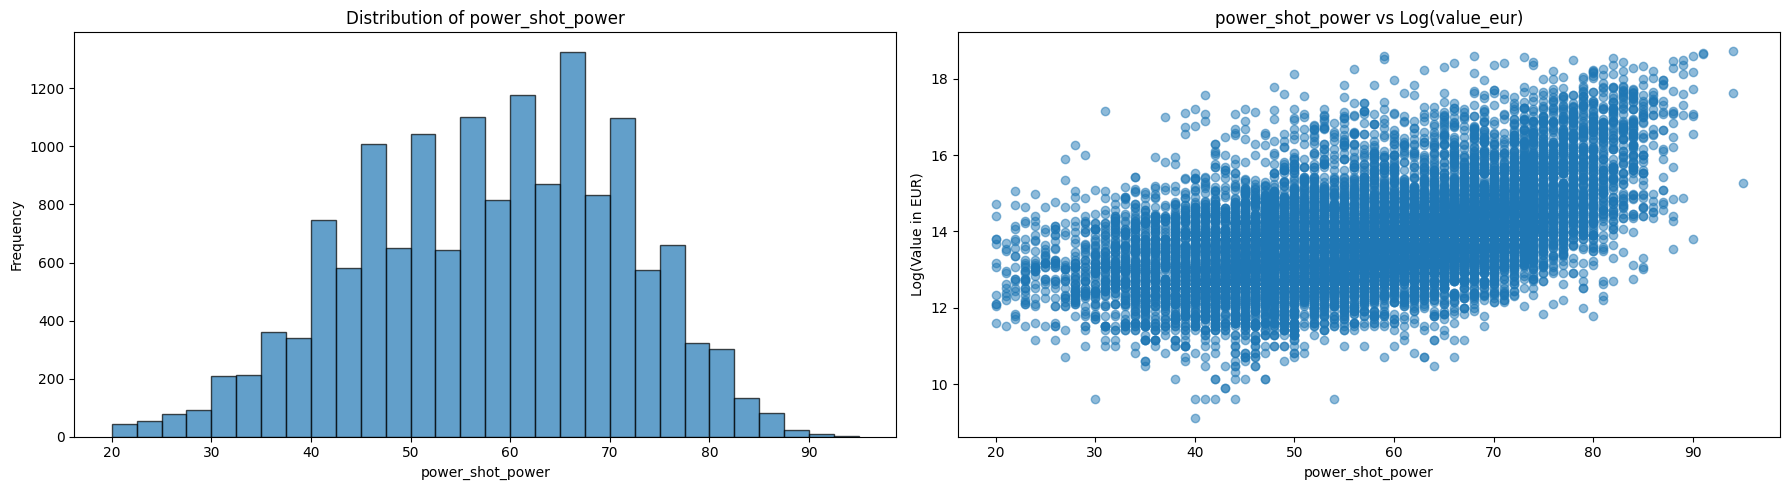

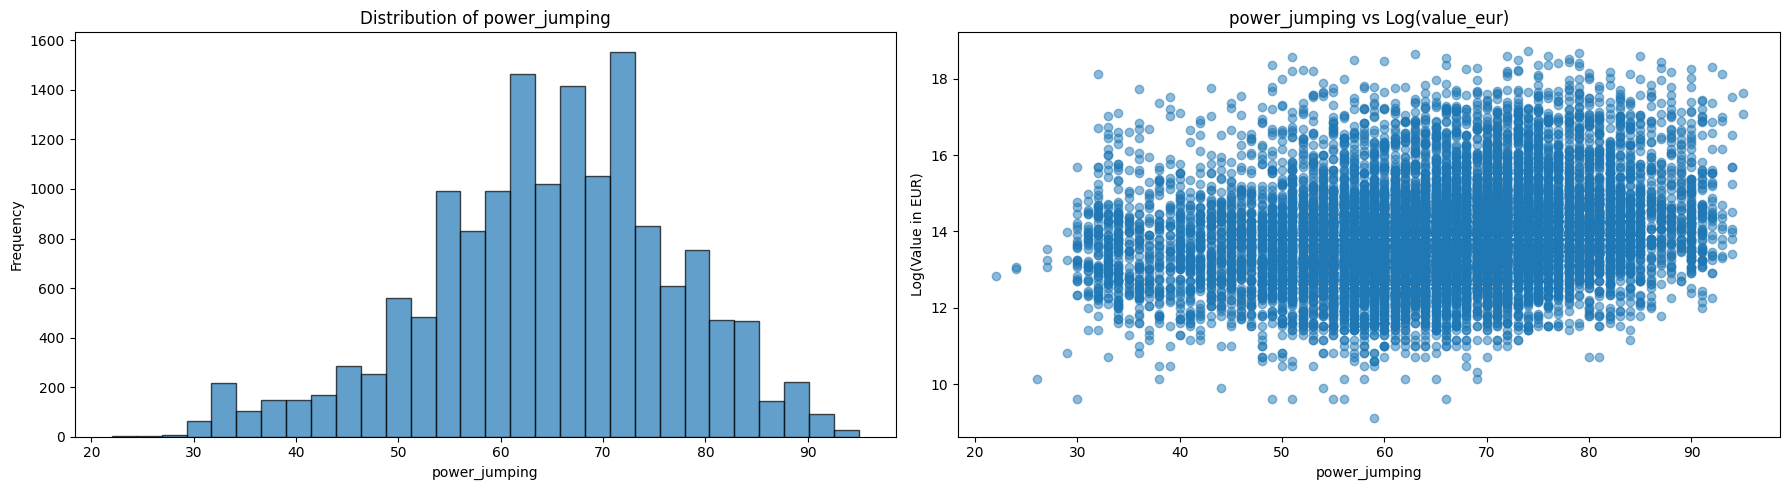

In [13]:
# Loop through each variable
for col in cols_left:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 3 plots side-by-side
    
    # Histogram
    axes[0].hist(train[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[0].set_title(f'Distribution of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Scatterplot vs log(value_eur)
    axes[1].scatter(train[col], log_target, alpha=0.5)
    axes[1].set_title(f'{col} vs Log(value_eur)')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Log(Value in EUR)')

    plt.tight_layout()
    plt.show()

Most variables show normal or slightly skewed distributions. From the scatterplots, several features such as overall and potential reveal a clear positive correlation with the log-transformed target, suggesting strong predictive potential. In contrast, variables like age and weight_kg demonstrate more non-linear relationships with the log-transformed target. 
The feature release_clause_eur initially appeared promising, showing a classic logarithmic pattern in its relationship with the target. This led us to include it in the log-transformed form. However, after training several models, we observed significant overfitting, raising concerns about potential data leakage, as this variable is often estimated based on a player's market value rather than determined independently. After removing it during feature engineering, model performance improved, and we ultimately decided to exclude this feature from the final set.

## 2. Preprocessing 

We define a function to load and clean the dataset, along with a separate preprocessing function that applies minimal transformations. This setup allows us to easily reuse the cleaning and preprocessing steps across different models.

In [14]:
def load_and_clean(filepath):
    # 1) Load the dataset and drop rows where the target variable 'value_eur' is missing
    df = pd.read_csv(filepath)
    df = df.dropna(subset=['value_eur'])
    
    # 2a) Separate the target variable
    y = df.pop('value_eur') # Remove 'value_eur' from df and store in y
    X = df.copy() # Create a copy of the features

    # 2b) Log-transform the target to reduce skewness
    y = np.log1p(y) # log1p = log(1 + x), handles zero values safely

    # 3a) Drop the features that miss more than 15% of their values
    X = X.drop(columns=drop_missing)

    # 3b) Remove previously identified irrelevant features 
    X = X.drop(columns=irrelevant_features)
    
    # 3c) Convert 'club_joined' to datetime and extract the year
    X['club_joined'] = pd.to_datetime(X['club_joined'], errors='coerce') # convert to datetime
    X['club_joined_year'] = X['club_joined'].dt.year # extract just the year
    X = X.drop(columns=['club_joined']) # original column no longer needed
    
    return X, y  # return cleaned features and transformed target

Define the preprocessor for numeric and categorical features.

In [34]:
preprocessor = ColumnTransformer([
    # Numeric preprocessing: median imputation + standard scaling
    ('num',
       Pipeline([
           ('imputer', SimpleImputer(strategy='median')),   # fill missing numeric with median
           ('scaler',   StandardScaler())                   # standardize numeric features
       ]),
       make_column_selector(dtype_include=np.number)        # apply to numeric columns only
    ),
    # Categorical preprocessing: constant imputation + one-hot encoding
    ('cat',
       Pipeline([
           ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')), # fill missing categorical with 'MISSING'
           ('onehot',  OneHotEncoder(handle_unknown='ignore',                     # convert categories to binary features
                                     sparse_output=False))
       ]),
       make_column_selector(dtype_exclude=np.number)                              # apply to categorical columns only 
    )
],
    remainder='drop'  # drop any remaining columns not explicitly handled
)

## 3. Feature engineering 

Here we define a custom transformer to apply additional feature engineering. This includes dropping variables that introduce multicollinearity (cols_to_drop), removing release_clause_eur and simplifying player positions into broader role categories to reduce dimensionality and mitigate overfitting.

In [35]:
def feat_eng(df, *, cols_to_drop=cols_to_drop):

    # Make a copy of the input DataFrame, dropping columns with too high correlation (ignore errors if missing)
    X = df.drop(columns=cols_to_drop, errors='ignore').copy()

    # Drop release_clause_eur due to data leakage 
    if 'release_clause_eur' in X:
        X = X.drop(columns=['release_clause_eur'])

    # Create role-based dummy variables from 'player_positions' 
    if 'player_positions' in X:
        # Define a mapping from specific positions to general role groups
        role_to_group = {
            'GK': 'Goalkeeper',
            'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender',
            'LWB': 'Defender', 'RWB': 'Defender',
            'CDM': 'Midfielder', 'CM': 'Midfielder', 'CAM': 'Midfielder',
            'LM': 'Midfielder', 'RM': 'Midfielder',
            'ST': 'Forward', 'CF': 'Forward', 'LW': 'Forward', 'RW': 'Forward'
        }

        # Initialize dummy columns to 0
        X['is_defender']   = 0
        X['is_midfielder'] = 0
        X['is_forward']    = 0
        X['is_goalkeeper'] = 0

        # Iterate over non-null 'player_positions' values
        for idx, pos in X['player_positions'].dropna().items():
            roles = [r.strip() for r in pos.split(',')]  # Split multiple roles
            groups = {role_to_group.get(r, 'Goalkeeper') for r in roles}  # Map to groups

            # Set dummy flags if player's role matches the group
            if 'Defender'   in groups: X.at[idx, 'is_defender']   = 1
            if 'Midfielder' in groups: X.at[idx, 'is_midfielder'] = 1
            if 'Forward'    in groups: X.at[idx, 'is_forward']    = 1
            if 'Goalkeeper' in groups: X.at[idx, 'is_goalkeeper'] = 1

        # Drop the original column after encoding
        X = X.drop(columns=['player_positions'])

    return X

# Wrap the feature engineering function as a scikit-learn-compatible transformer
feat_eng_step = FunctionTransformer(
    feat_eng,
    validate=False,  # Skip strict input validation to keep DataFrames
    kw_args={'cols_to_drop': cols_to_drop}  # Pass in the list of columns to drop
)


## 4. Baseline model 

Let's define our scorers that we will use to assess the performance of our models later.

In [36]:
# Custom RMSE function in EUR (not log-space)
def rmse_eur(log_true, log_pred):
    # Convert predictions and true values back from log-space using expm1 (inverse of log1p)
    return np.sqrt(mean_squared_error(np.expm1(log_true), np.expm1(log_pred)))

# Define a scorer to use with cross_val_score or GridSearchCV which minimises RMSE
eur_rmse = make_scorer(rmse_eur, greater_is_better=False)  

# Utility function to format mean ± std for output
def fmt(mean, std, decimals=0):
    return f"{mean:.{decimals}f} ± {std:.{decimals}f}"

### 4.1 Linear Regression
We trained a Linear Regression model on the preprocessed data and evaluated its performance using cross-validation. The results, reported below, reflect the model's average performance across multiple folds.

In [37]:
# Load data
X, y = load_and_clean('data/train.csv')

# Build Linear Regression pipeline
pipeline = Pipeline([
    ('feat_eng',  feat_eng_step),
    ('preprocess', preprocessor),
    ('model',      LinearRegression())
])

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Run cross-validation using RMSE scorer
cv_res = cross_validate(
    pipeline, X, y,
    scoring={"rmse": eur_rmse},
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)

# Extract and convert RMSE scores (make positive since scorer returns negative)
train_rmse = -cv_res["train_rmse"]
val_rmse   = -cv_res["test_rmse"]

# Print results
print("── 5-fold cross-validation RMSE (EUR) ──")
print(f"Train RMSE : {fmt(train_rmse.mean(), train_rmse.std())}")
print(f"Val   RMSE : {fmt(val_rmse.mean(),   val_rmse.std())}")

── 5-fold cross-validation RMSE (EUR) ──
Train RMSE : 2079666 ± 148163
Val   RMSE : 2198263 ± 608412


The validation RMSE is only about 5% higher than the training RMSE, indicating relatively low overfitting. However, the absolute error values remain quite high, suggesting that a simple linear model may not fully capture the underlying complexity of the data. More flexible models or further feature engineering may be needed to improve performance.

### 4.2 Lasso 
As another baseline model, we chose Lasso Regression because it automatically selects the most important features by setting many coefficients to zero. Since Lasso already performs regularization and feature selection, we applied only minimal preprocessing—basic imputation and scaling—keeping the model simple and easy to interpret.

In [38]:
# Load features and target from the cleaned dataset
X, y = load_and_clean('data/train.csv')

# Define a range of alpha values to search for regularization strength
# We use a log scale between 1e-5 and 1e-3 (20 values)
alpha_search = np.logspace(-5, -3, 20)

# Create a pipeline with LassoCV to automatically select the best alpha
pipeline_cv = Pipeline([
    ('feat_eng',  feat_eng_step), # Apply custom feature engineering
    ('preprocess', preprocessor), # Handle missing values, scale numerics, encode categoricals
    ('model', LassoCV(
        alphas=alpha_search,    # Try different alpha values from the search space
        cv=5,                   # Internal 5-fold CV used by LassoCV to select alpha
        max_iter=10_000, 
        n_jobs=-1, 
        random_state=RANDOM_STATE))
])

# Fit the pipeline with LassoCV to the entire dataset
pipeline_cv.fit(X, y)

# Extract the best alpha value found during cross-validation
best_alpha = pipeline_cv.named_steps['model'].alpha_
print(f"Best α from internal CV: {best_alpha:.6f}")

# Final pipeline using best alpha
lasso_pipe = Pipeline([
    ('feat_eng',  feat_eng_step),
    ('preprocess', preprocessor),
    ('model', Lasso(
        alpha=best_alpha,       # Use the best alpha found
        max_iter=10_000))
])

# Use external 5-fold cross-validation to evaluate the final Lasso model
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Evaluate the model using custom RMSE scorer 
cv_res = cross_validate(
    lasso_pipe, X, y,
    scoring={"rmse": eur_rmse},
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

# Convert RMSE results to positive values (since scorers return negative for minimization)
train_rmse = -cv_res["train_rmse"]
val_rmse   = -cv_res["test_rmse"]

# Print results
print("── 5-fold cross-validation RMSE (EUR) ──")
print(f"Train RMSE : {fmt(train_rmse.mean(), train_rmse.std())}")
print(f"Val   RMSE : {fmt(val_rmse.mean(),   val_rmse.std())}")


Best α from internal CV: 0.000089
── 5-fold cross-validation RMSE (EUR) ──
Train RMSE : 2143019 ± 136332
Val   RMSE : 2168842 ± 589284


## 5. Complex Models 

We now move on to fitting more complex models to improve predictive performance.

### 5.1 Decision Tree

In [39]:
# Load features and target from the cleaned dataset
X, y = load_and_clean('data/train.csv')

# Decision Tree Pipeline
tree_pipe = Pipeline(steps=[
    ("feat_eng", feat_eng_step),          
    ("prep"    , preprocessor),           
    ("model"   , DecisionTreeRegressor(
        random_state=RANDOM_STATE,                  # reproducibility
        min_samples_leaf=5,               # tuned parameter
    )),
])

# Hyper-parameter grid  
param_grid = {
    "model__max_depth":        [None, 10, 20, 30],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__ccp_alpha":        [0.0, 0.0005, 0.001, 0.005],
}

# Define 5-fold cross-validation strategy with shuffled splits
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV to find best hyperparameters based on euro-scale RMSE
gs = GridSearchCV(
    tree_pipe,            # Pipeline to tune
    param_grid,           # Parameter grid to search
    scoring=eur_rmse,     # Custom RMSE scorer
    cv=cv,                # 5-fold CV
    n_jobs=-1,            # Use all available CPU cores
    return_train_score=True,
)

# Fit grid-search on the full dataset
gs.fit(X, y)

# Print the best combination of hyperparameters and corresponding CV score
print("\nBest hyper-parameters:", gs.best_params_)
print(f"Best CV RMSE (EUR): {-gs.best_score_:,.0f}")


Best hyper-parameters: {'model__ccp_alpha': 0.0, 'model__max_depth': None, 'model__min_samples_leaf': 5}
Best CV RMSE (EUR): 1,327,502


### 5.2 Random Forest

In [59]:
# Load features and target from the cleaned dataset
X, y = load_and_clean('data/train.csv')

# Random Forest Pipeline
rf_pipe = Pipeline([
    ("feat_eng", feat_eng_step),     
    ("prep"    , preprocessor),      
    ("model"   , RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
])

# Hyper-parameter grid 
param_grid = {
    "model__n_estimators":     [500, 700],
    "model__max_depth":        [None, 20, 30],
    "model__min_samples_leaf": [2, 5],
}

# Define 5-fold cross-validation strategy with shuffled splits
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV to find best hyperparameters based on euro-scale RMSE
gs = GridSearchCV(
    rf_pipe,              # Pipeline to tune
    param_grid,           # Parameter grid to search
    scoring=eur_rmse,     # Custom RMSE scorer
    cv=cv,                # 5-fold CV
    n_jobs=-1,            # Use all available CPU cores
    return_train_score=True,
)

# Fit grid-search on the full dataset
gs.fit(X, y)


print("\nBest hyper-parameters:", gs.best_params_)
print(f"Best CV RMSE (EUR): {-gs.best_score_:,.0f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best hyper-parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__n_estimators': 500}
Best CV RMSE (EUR): 961,981


### 5.3 XGBoost 

In [38]:
# Load features and target from the cleaned dataset
X, y = load_and_clean('data/train.csv')

# XGBoost Pipeline
xgb_pipe = Pipeline([
    ("feat_eng", feat_eng_step),     
    ("prep"    , preprocessor),      
    ("model"   , XGBRegressor(
        objective="reg:squarederror",  # for regression
        eval_metric   = "rmse",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0,
        tree_method = "hist"      # speed-up
    ))
])

# Hyper-parameter grid 
param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [2, 3],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.7, 1.0],
    "model__colsample_bytree": [0.7, 1.0],
}

# Define 5-fold cross-validation strategy with shuffled splits
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearchCV to find best hyperparameters based on euro-scale RMSE
gs = GridSearchCV(
    xgb_pipe,               # Pipeline to tune
    param_grid,             # Parameter grid to search
    scoring=eur_rmse,       # Custom RMSE scorer
    cv=cv,                  # 5-fold CV
    n_jobs=-1,              # Use all available CPU cores
    return_train_score=True
)

# Fit grid-search on the full dataset
gs.fit(X, y)

print("\nBest hyper-parameters:", gs.best_params_)
print(f"Best CV RMSE (EUR): {-gs.best_score_:,.0f}")


Best hyper-parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 500, 'model__subsample': 0.7}
Best CV RMSE (EUR): 592,962


### 5.4 Models Comparison
We compared the models by evaluating their performance using cross-validation, focusing on the best-performing configuration of each of the three complex models we trained. For each model, we recorded the training error, test error, and the percentage difference between them as an indicator of overfitting.

In [41]:
# 1 ─ Decision Tree
tree_reg = DecisionTreeRegressor(
    ccp_alpha=0.0,              # No cost-complexity pruning
    max_depth=None,             # Tree expands until all leaves are pure or contain < min_samples_leaf samples
    min_samples_leaf=5,         # Minimum number of samples required to be at a leaf node
    random_state=RANDOM_STATE   # Ensures reproducibility
)

# Build pipeline: feature engineering → preprocessing → decision tree model
best_tree_pipe = Pipeline([
    ("feat_eng", feat_eng_step),        # Custom feature engineering step
    ('preprocess', preprocessor),       # Handle missing values, encoding, scaling.
    ('model', tree_reg),                # Decision Tree Regressor
])

# 2 ─ Random Forest
rf_reg = RandomForestRegressor(
    max_depth=30,               # Maximum depth of each tree
    min_samples_leaf=2,         # Minimum samples required at a leaf node
    n_estimators=500,           # Number of trees in the forest
    n_jobs=-1,                  # For parallel processing
    random_state=RANDOM_STATE   # Ensures reproducibility
)

# Build pipeline: feature engineering → preprocessing → Random Forest model
best_rf_pipe = Pipeline([
    ("feat_eng", feat_eng_step),        # Custom feature engineering step
    ('preprocess', preprocessor),       # Handle missing values, encoding, scaling.
    ('model', rf_reg),                  # Random Forest Regressor
])

# 3 ─ XGBoost
xgb_reg = XGBRegressor(
    colsample_bytree=1.0,               # Use all features for each tree
    learning_rate=0.1,                  # Step size shrinkage to prevent overfitting
    max_depth=2,                        # Maximum depth of a tree 
    n_estimators=500,                   # Number of boosting rounds (trees)
    subsample=0.7,                      # Fraction of samples used per tree (adds regularization)
    objective='reg:squarederror',       # Regression with squared loss
    n_jobs=-1,                          # For parallel processing
    random_state=RANDOM_STATE,          # Ensures reproducibility
    tree_method='hist',                 # Faster histogram-based tree growth
)
best_xgb_pipe = Pipeline([
    ("feat_eng", feat_eng_step),        # Custom feature engineering step
    ('preprocess', preprocessor),       # Handle missing values, encoding, scaling.
    ('model', xgb_reg),                 # XGBoost Regressor
])

In [42]:
# Load and clean training data (returns feature matrix X and target vector y)
X, y = load_and_clean("data/train.csv")


# Define a function to run cross-validation and return relevant metrics
def run_cv(name, pipe):
    res = cross_validate(
        pipe,
        X, y,
        scoring={"rmse": eur_rmse},
        cv=cv,
        n_jobs=5,                   # parallize 
        return_train_score=True,    # capture both train and validation scores
    )
    train_rmse = -res["train_rmse"]   # make RMSE positive
    val_rmse = -res["test_rmse"]
    delta = 100 * (val_rmse.mean() - train_rmse.mean()) / train_rmse.mean() # % diff
    return train_rmse, val_rmse, delta


# Run CV for each model pipeline
xgb_train,  xgb_val,  xgb_delta  = run_cv("XGB",  best_xgb_pipe)
rf_train,   rf_val,   rf_delta   = run_cv("RF",   best_rf_pipe)
tree_train, tree_val, tree_delta = run_cv("TREE", best_tree_pipe)

# Print results
print("── Model Comparison ──")
print("Model               | Train RMSE (EUR) | Val RMSE (EUR) | % Δ")
print("──────────────────────────────────────────────────────────────")
print(f"XGBoost             | {fmt(xgb_train.mean(),  xgb_train.std())} "
      f"| {fmt(xgb_val.mean(),   xgb_val.std())}   | {xgb_delta:+.2f}%")
print(f"Random Forest       | {fmt(rf_train.mean(),   rf_train.std())} "
      f"| {fmt(rf_val.mean(),    rf_val.std())}    | {rf_delta:+.2f}%")
print(f"Decision Tree       | {fmt(tree_train.mean(), tree_train.std())} "
      f"| {fmt(tree_val.mean(),  tree_val.std())}  | {tree_delta:+.2f}%")


── Model Comparison ──
Model               | Train RMSE (EUR) | Val RMSE (EUR) | % Δ
──────────────────────────────────────────────────────────────
XGBoost             | 493206 ± 10840 | 592962 ± 122573   | +20.23%
Random Forest       | 467297 ± 27155 | 961981 ± 231763    | +105.86%
Decision Tree       | 981230 ± 175596 | 1327502 ± 149798  | +35.29%


We selected XGBoost as the final model because it offered the best balance between performance, generalization, and training time. Specifically, it achieved the lowest validation RMSE (approximately €592,000), showed the lowest overfitting, and demonstrated low variance across cross-validation folds.

Simpler models we analyzed in the Baseline section like Linear Regression and Lasso suffered from underfitting. On the other hand, Decision Tree models trained quickly but performed poorly in terms of validation error, while Random Forest models required significantly more training time and still exhibited noticeable overfitting.

Considering all these factors, XGBoost proved to be the most robust and reliable choice.

## 6. Submission file
We train our final model on the full training dataset. The pipeline includes preprocessing, feature engineering and the XGBoost estimator. The target variable has been log-transformed (log1p(value_eur)) to reduce skewness and improve model performance. The trained pipeline is stored for generating predictions on the test set.

In [20]:
# Load and preprocess the training data
X_train, y_train = load_and_clean("data/train.csv")

# Fit the XGBoost pipeline on the training data
best_xgb_pipe.fit(X_train, y_train)

# Save the trained pipeline to a variable named 'model' for later use (e.g. prediction)
model = best_xgb_pipe

To ensure consistency between the training and test data, we define a function that replicates the transformations from the load_and_clean function, excluding those applied to the target variable value_eur, which is not available in the test set. It includes dropping irrelevant and highly incomplete features, and converting date columns. The resulting DataFrame is ready to be passed through the prediction pipeline.

In [ ]:
def prepare_test(path):
    df = pd.read_csv(path)

    # Apply the same feature transformations as done in the training set

    X = df.copy() # Work on a copy to preserve the original dataframe

    X = X.drop(columns=drop_missing) # Drop columns with the highest proportion of missing values (as previously identified)
    
    X = X.drop(columns=irrelevant_features) # Drop features irrelevant for prediction

    X["club_joined"] = pd.to_datetime(X["club_joined"], errors="coerce") # Convert 'club_joined' to datetime format
    X["club_joined_year"] = X["club_joined"].dt.year # Extract the year component from 'club_joined' and store it in a new column
    X = X.drop(columns=["club_joined"]) # Drop the original 'club_joined' column after extracting useful information
    
    return X # Return the processed test feature set

Predictions are initially obtained on the log scale and then converted back to the original euro scale using the inverse of the log1p transformation. We also ensure that no negative values are predicted. Finally, we assemble the results into the required submission format and save them as a CSV file ready for upload.

In [ ]:
# Load the raw test data (including identifier column needed for submission)
raw_test = pd.read_csv("data/test.csv")

# Apply the same preprocessing steps as in training (except those for the target variable)
X_test = prepare_test("data/test.csv")

# Predict log-transformed target values using the trained pipeline
y_pred_log = model.predict(X_test)

# Inverse the log1p transformation to get predictions back on the euro scale
y_pred = np.expm1(y_pred_log)

# Safety check: clip any negative predictions to 0 (market value can't be negative)
y_pred = np.clip(y_pred, 0, None)

# Create assemble submission
submission = pd.DataFrame({
    "Unnamed: 0": raw_test["Unnamed: 0"], # Match ID column from the test set
    "value_eur" : y_pred.astype(float),   # Ensure proper float format
})

submission.to_csv("submission.csv", index=False)
print("✓ submission.csv created — shape:", submission.shape)


✓ submission.csv created — shape: (3848, 2)
